In [1]:
# Transformers installation
! pip install transformers datasets
# To install from source instead of the last release, comment the command above and uncomment the following one.
# ! pip install git+https://github.com/huggingface/transformers.git


In [68]:
from datasets import load_dataset, DatasetDict
from tqdm import tqdm
import pickle
import torch
from torch.utils.data import DataLoader
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix

from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

from transformers import BertForSequenceClassification

from torch.optim import AdamW
from transformers import get_scheduler
from IPython.core.display import display, HTML

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda


In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [37]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()

## Prepare a dataset

Before you can fine-tune a pretrained model, download a dataset and prepare it for training. The previous tutorial showed you how to process data for training, and now you get an opportunity to put those skills to the test!

Begin by loading the [Yelp Reviews](https://huggingface.co/datasets/yelp_review_full) dataset:

In [5]:
dataset = load_dataset("yelp_review_full")
dataset

Generating train split:   0%|          | 0/650000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset yelp_review_full downloaded and prepared to /root/.cache/huggingface/datasets/yelp_review_full/yelp_review_full/1.0.0/e8e18e19d7be9e75642fc66b198abadb116f73599ec89a69ba5dd8d1e57ba0bf. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 650000
    })
    test: Dataset({
        features: ['label', 'text'],
        num_rows: 50000
    })
})

In [6]:
dataset['train'].features

{'label': ClassLabel(num_classes=5, names=['1 star', '2 star', '3 stars', '4 stars', '5 stars'], id=None),
 'text': Value(dtype='string', id=None)}

In [7]:
# random sampling
dataset = DatasetDict({"train" :dataset["train"].shuffle(seed=42).select(range(10000)),
                       "val" :dataset["train"].shuffle(seed=42).select(range(10000,11000)),
                       "test":  dataset["test"].shuffle(seed=42).select(range(1000))})

Loading cached shuffled indices for dataset at /root/.cache/huggingface/datasets/yelp_review_full/yelp_review_full/1.0.0/e8e18e19d7be9e75642fc66b198abadb116f73599ec89a69ba5dd8d1e57ba0bf/cache-679ebfcca6f71e2a.arrow


## Tokenized input length

### Plot the distribution of sequence length

In [8]:
def seq_len(dt, split):
    '''
    input:
        dt: dataset
        split: 'train' or 'test'
    output distribution plot of sequence length in dataset
    '''

    df = dt[split].to_pandas()

    seq_len = []

    for txt in tqdm(df.text):
        tokens = tokenizer.encode(txt, max_length=None)
        seq_len.append(len(tokens))
    
    # plot the distribution of tokenized sentence length in train and test
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))

    sns.distplot(seq_len, ax=ax)

    ax.set_title('Distribution of Sequence Length', fontsize=14)
    ax.set_xlabel('Number of Tokens', fontsize=12)
    ax.set_ylabel('Density', fontsize=12)

    plt.tight_layout()
    plt.figure(facecolor='white', edgecolor='white')

100%|██████████| 1000/1000 [00:03<00:00, 303.88it/s]
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


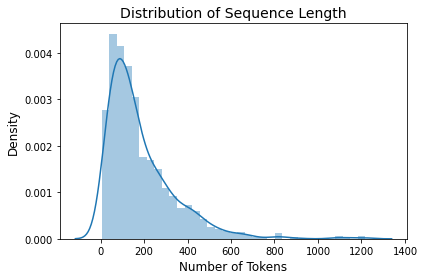

<Figure size 432x288 with 0 Axes>

In [9]:
seq_len(dataset, 'test')

### Tokenize data

In [10]:
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", max_length=512, truncation=True)

# tokenized_datasets = to_token.map(tokenize_function, batched=True)
tokenized_datasets = dataset.map(tokenize_function, batched=True)
tokenized_datasets

  0%|          | 0/10 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'text', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 10000
    })
    val: Dataset({
        features: ['label', 'text', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['label', 'text', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1000
    })
})

In [11]:
test_text = tokenized_datasets['test']['text']
test_text[:5]

['Kabuto is your run-of-the-mill Japanese Steakhouse. Different stations with chefs slinging shrimp tails around the communal dining areas like it\'s a lunchtime magic show. Always a plethora of laughs and gags going around the group. \\n\\nThis place is great for lunch. $9 and 30 minutes and you\'re out the door. Uhhh...If I\'m craving a salad with ginger dressing, which I always am, (you do too. admit it) fried rice, steak, shrimp and white sauce (DUDE) then Kabuto is king of lunch options in my book. Always super clean and full of kindhearted staff. The parking lot is super difficult to get in and out of though. 51 traffic at lunch is a beast. Good luck getting stuck behind someone trying to cut across traffic at 12pm on a weekday. It\'s murder. This place would greatly benefit from another exit/entrance or a stoplight. Here\'s hoping....\\n\\nYou can\'t really shake a stick at balanced lunch when you can have soup or a salad, veggies, fried rice and a choice of a protein for under 

In [12]:
tokenized_datasets = tokenized_datasets.remove_columns(["text"])
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
tokenized_datasets.set_format("torch")
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 10000
    })
    val: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1000
    })
})

In [13]:
# count per class
print(torch.bincount(tokenized_datasets['train']['labels']))
print(torch.bincount(tokenized_datasets['val']['labels']))
print(torch.bincount(tokenized_datasets['test']['labels']))

tensor([2035, 1977, 1943, 1991, 2054])
tensor([203, 201, 207, 208, 181])
tensor([220, 213, 196, 205, 166])


## Fine-tune BERT in PyTorch

### Specify layers to freeze/fine-tune

Create a `DataLoader` for your training and test datasets so you can iterate over batches of data:

In [14]:
batch_size = 128
train_dataloader = DataLoader(tokenized_datasets['train'], shuffle=True, batch_size=batch_size)
val_dataloader = DataLoader(tokenized_datasets['val'], batch_size=batch_size)
test_dataloader = DataLoader(tokenized_datasets['test'], batch_size=batch_size)
print(len(train_dataloader))
print(len(val_dataloader))
print(len(test_dataloader))

79
8
8


In [15]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=5).to(device)

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [16]:
total_params = 0

for x in filter(lambda p: p.requires_grad, model.parameters()):
    total_params += np.prod(torch.Tensor.cpu(x).data.numpy().shape)
print("Total number of params", total_params)
print("Total layers", len(list(filter(lambda p: p.requires_grad and len(p.data.size()) > 1, model.parameters()))))

Total number of params 109486085
Total layers 77


In [17]:
# freeze certain layers in pretrain
modules = [model.bert.embeddings, model.bert.encoder.layer[:11]] 
for module in modules:
    for param in module.parameters():
        param.requires_grad = False

In [18]:
total_params = 0

for x in filter(lambda p: p.requires_grad, model.parameters()):
    total_params += np.prod(torch.Tensor.cpu(x).data.numpy().shape)
print("Total number of params", total_params)
print("Total layers", len(list(filter(lambda p: p.requires_grad and len(p.data.size()) > 1, model.parameters()))))

Total number of params 7682309
Total layers 8


In [19]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)

bert.encoder.layer.11.attention.self.query.weight
bert.encoder.layer.11.attention.self.query.bias
bert.encoder.layer.11.attention.self.key.weight
bert.encoder.layer.11.attention.self.key.bias
bert.encoder.layer.11.attention.self.value.weight
bert.encoder.layer.11.attention.self.value.bias
bert.encoder.layer.11.attention.output.dense.weight
bert.encoder.layer.11.attention.output.dense.bias
bert.encoder.layer.11.attention.output.LayerNorm.weight
bert.encoder.layer.11.attention.output.LayerNorm.bias
bert.encoder.layer.11.intermediate.dense.weight
bert.encoder.layer.11.intermediate.dense.bias
bert.encoder.layer.11.output.dense.weight
bert.encoder.layer.11.output.dense.bias
bert.encoder.layer.11.output.LayerNorm.weight
bert.encoder.layer.11.output.LayerNorm.bias
bert.pooler.dense.weight
bert.pooler.dense.bias
classifier.weight
classifier.bias


### Optimizer and learning rate scheduler

In [20]:
optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=2e-5, weight_decay=1e-2)

In [21]:
num_epochs = 10
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(name="linear", optimizer=optimizer, num_warmup_steps=3, num_training_steps=num_training_steps)

### Training loop

To keep track of your training progress, use the [tqdm](https://tqdm.github.io/) library to add a progress bar over the number of training steps:

In [22]:
from tqdm import tqdm_notebook

def train(model, dataloader, optimizer, scheduler):

    # Record total loss
    epoch_loss = 0.0
    epoch_hits = 0
    n_samples = 0

    # Get the progress bar for later modification
    progress_bar = tqdm_notebook(dataloader, ascii=True)

    model.train()
    # Mini-batch training
    for batch in dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        epoch_loss += loss

        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        epoch_hits += torch.sum(predictions == batch["labels"])
        n_samples += len(batch["labels"])

        loss.backward()
        # nn.utils.clip_grad_norm_(filter(lambda p: p.requires_grad, model.parameters()), max_norm=1.0)

        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

    return epoch_loss/len(dataloader), epoch_hits/n_samples

def evaluate(model, dataloader):
    # Set the model to eval mode to avoid weights update
    epoch_loss = 0.0
    epoch_hits = 0
    n_samples = 0
    _layer = -1      # get the last layer
    hidden = []      # hidden state

    progress_bar = tqdm_notebook(dataloader, ascii=True)

    model.eval()
    for batch in dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch, output_hidden_states=True)

        hidden.append(outputs.hidden_states[_layer][:,0,:])       # get the embed vector from [CLS] and last layer
        
        loss = outputs.loss
        epoch_loss += loss

        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        epoch_hits += torch.sum(predictions == batch["labels"])
        n_samples += len(batch["labels"])
        progress_bar.update(1)
    
    # concat hidden layers from different batch
    hidden = torch.cat(hidden, 0)

    return epoch_loss/len(dataloader), epoch_hits/n_samples, hidden


-----------------------------------
Epoch 1
-----------------------------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


  0%|          | 0/79 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/8 [00:00<?, ?it/s]

Training Loss: 1.4783. Validation Loss: 1.2644. 
Training Accuracy: 0.3646. Validation Accuracy: 0.4790. 


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


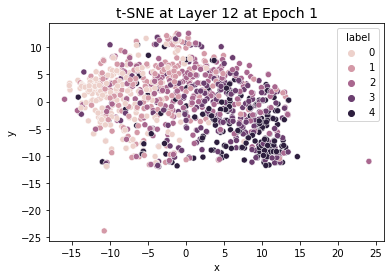

-----------------------------------
Epoch 2
-----------------------------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


  0%|          | 0/79 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/8 [00:00<?, ?it/s]

Training Loss: 1.1354. Validation Loss: 1.0714. 
Training Accuracy: 0.5140. Validation Accuracy: 0.5400. 
-----------------------------------
Epoch 3
-----------------------------------


  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Training Loss: 1.0202. Validation Loss: 1.0188. 
Training Accuracy: 0.5578. Validation Accuracy: 0.5680. 
-----------------------------------
Epoch 4
-----------------------------------


  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Training Loss: 0.9733. Validation Loss: 1.0085. 
Training Accuracy: 0.5746. Validation Accuracy: 0.5690. 
-----------------------------------
Epoch 5
-----------------------------------


  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Training Loss: 0.9569. Validation Loss: 1.0057. 
Training Accuracy: 0.5873. Validation Accuracy: 0.5740. 
-----------------------------------
Epoch 6
-----------------------------------


  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Training Loss: 0.9394. Validation Loss: 0.9997. 
Training Accuracy: 0.5976. Validation Accuracy: 0.5750. 
-----------------------------------
Epoch 7
-----------------------------------


  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Training Loss: 0.9351. Validation Loss: 0.9981. 
Training Accuracy: 0.5954. Validation Accuracy: 0.5760. 
-----------------------------------
Epoch 8
-----------------------------------


  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Training Loss: 0.9233. Validation Loss: 0.9964. 
Training Accuracy: 0.5942. Validation Accuracy: 0.5820. 
-----------------------------------
Epoch 9
-----------------------------------


  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Training Loss: 0.9213. Validation Loss: 0.9940. 
Training Accuracy: 0.5980. Validation Accuracy: 0.5770. 
-----------------------------------
Epoch 10
-----------------------------------


  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Training Loss: 0.9183. Validation Loss: 0.9937. 
Training Accuracy: 0.6046. Validation Accuracy: 0.5770. 


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


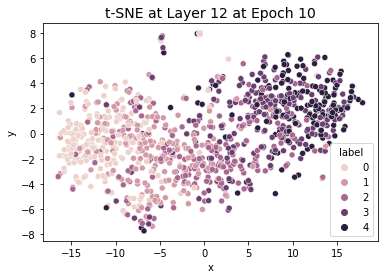

In [23]:
train_loss_history = []
train_acc_history = []
valid_loss_history = []
valid_acc_history = []

tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300, init='pca', random_state=128)

for epoch_idx in range(num_epochs):
    print("-----------------------------------")
    print("Epoch %d" % (epoch_idx+1))
    print("-----------------------------------")
    
    train_loss, train_acc = train(model, train_dataloader, optimizer, lr_scheduler)
    val_loss, val_acc, hidden = evaluate(model, val_dataloader)

    print("Training Loss: %.4f. Validation Loss: %.4f. " % (train_loss, val_loss))
    print("Training Accuracy: %.4f. Validation Accuracy: %.4f. " % (train_acc, val_acc))

    train_loss_history.append(train_loss.item())
    train_acc_history.append(train_acc.item())
    valid_loss_history.append(val_loss.item())
    valid_acc_history.append(val_acc.item())

    # plot t-SNE from the last layer at the first and last epoch
    if epoch_idx in [0, 9]:
        dim_reduced_embeds = tsne.fit_transform(torch.Tensor.cpu(hidden))
        df = pd.DataFrame.from_dict({'x':dim_reduced_embeds[:,0],'y':dim_reduced_embeds[:,1],'label':torch.Tensor.cpu(tokenized_datasets['val']['labels'])})
        df.label = df.label.astype(int)
        sns.scatterplot(data=df, x='x', y='y', hue='label')
        plt.title('t-SNE at Layer 12 at Epoch %d'%(epoch_idx+1), fontsize=14)
        plt.show()

<Figure size 432x288 with 0 Axes>

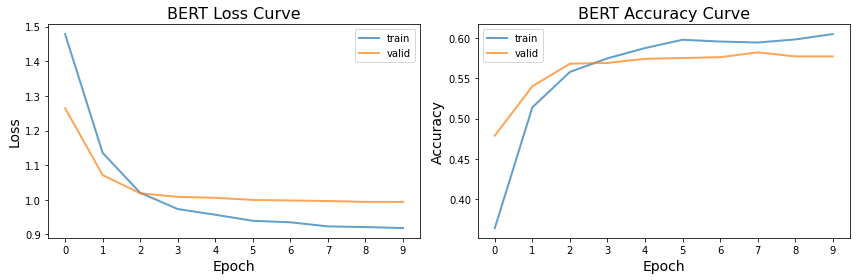

<Figure size 432x288 with 0 Axes>

In [24]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# fig 1: loss
ax1.plot(train_loss_history, color='C0', linestyle='solid', lw=2, label='train', alpha=0.7)
ax1.plot(valid_loss_history, color='C1', linestyle='solid', lw=2, label='valid', alpha=0.7)

# fig 2: accuracy
ax2.plot(train_acc_history, color='C0', linestyle='solid', lw=2, label='train', alpha=0.7)
ax2.plot(valid_acc_history, color='C1', linestyle='solid', lw=2, label='valid', alpha=0.7)

ax1.set_title('BERT Loss Curve', fontsize=16)
ax1.set_xlabel('Epoch', fontsize=14)
ax1.set_xticks(range(10))
ax1.set_ylabel('Loss', fontsize=14)
ax1.legend(loc='best')

ax2.set_title('BERT Accuracy Curve', fontsize=16)
ax2.set_xlabel('Epoch', fontsize=14)
ax2.set_xticks(range(10))
ax2.set_ylabel('Accuracy', fontsize=14)   
ax2.legend(loc='best')

plt.tight_layout()
plt.figure(facecolor='white', edgecolor='white')
# plt.savefig('BERT training curve.png')

## Evaluate on test set

In [29]:
import numpy as np
from datasets import load_metric

f1 = load_metric('f1')
acc = load_metric('accuracy')

model.eval()
for batch in test_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)         

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    f1.add_batch(predictions=predictions, references=batch["labels"])
    acc.add_batch(predictions=predictions, references=batch["labels"])

print(f1.compute(average=None))
print(acc.compute())


{'f1': array([0.74778761, 0.55477855, 0.54545455, 0.4972973 , 0.69230769])}
{'accuracy': 0.611}


## t-SNE by layer in final model

In [30]:
def tSNE(layer):

    tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300, init='pca', random_state=128)
    
    _layer = layer     # select the encoder layer

    hidden = []

    with torch.no_grad():
        for batch in test_dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            hidden_states = model(**batch, output_hidden_states=True).hidden_states
            hidden.append(hidden_states[_layer][:,0,:])       # get the embed vector from [CLS]
                
    hidden = torch.cat(hidden, 0)

    dim_reduced_embeds = tsne.fit_transform(torch.Tensor.cpu(hidden))

    df = pd.DataFrame.from_dict({'x':dim_reduced_embeds[:,0],'y':dim_reduced_embeds[:,1],'label':torch.Tensor.cpu(tokenized_datasets['test']['labels'])})
    df.label = df.label.astype(int)
    sns.scatterplot(data=df,x='x',y='y',hue='label')
    plt.title('t-SNE at Encoder Layer %d'%_layer, fontsize=14)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.001s...
[t-SNE] Computed neighbors for 1000 samples in 0.160s...


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.225603
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.953583
[t-SNE] KL divergence after 300 iterations: 1.327415


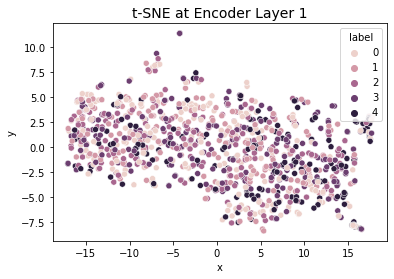

In [31]:
tSNE(1)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.001s...
[t-SNE] Computed neighbors for 1000 samples in 0.078s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 3.523284


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.273827
[t-SNE] KL divergence after 300 iterations: 1.258133


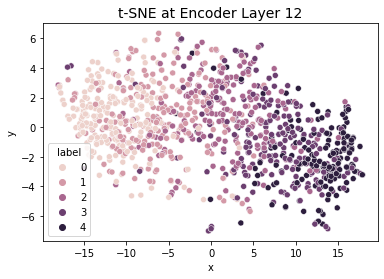

In [32]:
tSNE(12)

## Save and Load Model

In [65]:
# save
model.save_pretrained('/content/drive/MyDrive/Bert_base_tuned')

In [ ]:
# load
model = BertForSequenceClassification.from_pretrained("/content/drive/MyDrive/Bert_base_tuned").to(device)
model

## Attention Visualization

In [71]:
# use smaller batch size to avoid memory issue
test_dataloader = DataLoader(tokenized_datasets['test'], batch_size=32)

In [70]:
ids_all = []
attentions_all = []
predictions_all = []

with torch.no_grad():
    for i_batch, batch in enumerate(test_dataloader):
        batch = {k: v.to(device) for k, v in batch.items()}

        outputs = model(**batch, output_attentions=True)
        attentions = outputs.attentions  # a tuple of length 12, 12 encoder layers of BERT
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        # select attention from the last encoder layer, all sentences, embed vector of [CLS]     
        att_last_layer = torch.max(attentions[-1][:,:,0], 1)[0]       # max over 12 heads

        ids_all.append(batch['input_ids'])
        attentions_all.append(att_last_layer)
        predictions_all.append(predictions)

ids_all = torch.cat(ids_all, 0)
attentions_all = torch.cat(attentions_all, 0)
predictions_all = torch.cat(predictions_all, 0)

In [73]:
# https://medium.com/analytics-vidhya/a-gentle-introduction-to-implementing-bert-using-hugging-face-35eb480cff3

def get_length_without_special_tokens(token):
    length = 0
    for i in token:
        if i == 0:
            break
        else:
            length += 1
    return length

def print_attention(input_ids_all, attentions_all, tokenizer):
    attns = []
    for idx, (input_ids, attention, pred, true) in enumerate(zip(input_ids_all, attentions_all, predictions_all, tokenized_datasets['test']['labels'])):     # iter over examples
        if abs(true-pred) > 2:
            html = []
            len_input_ids = get_length_without_special_tokens(input_ids)
            input_ids = input_ids[:len_input_ids]
            attention = attention[:len_input_ids]
            for input_id, attention_value in zip(input_ids, attention):     # iter over token_ids
                token = tokenizer.convert_ids_to_tokens(input_id.item())
                attn = attention_value * 2         # color intensity
                html_color = '#%02X%02X%02X' % (255, int(255*(1 - attn)), int(255*(1 - attn)))      # attn in range(0, 1),（255，255，255) -> white, (255, 0, 0) -> red
                html.append('<span style="background-color: {}">{}</span>'.format(html_color, token))
                attns.append(attention_value)

            html_string = " ".join(html)
            print('-'*180)
            print('Example %d pred class: %d, true class: %d'%(idx, pred, true))
            display(HTML(html_string))

In [72]:
a = [1,2,3]
b = [4,5,6]
for i, (e1, e2) in enumerate(zip(a,b)):
    print(i, (e1,e2))

0 (1, 4)
1 (2, 5)
2 (3, 6)


### Visualize attention weights on misclassified examples

In [74]:
print_attention(ids_all, attentions_all, tokenizer)

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Example 71 pred class: 3, true class: 0


------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Example 80 pred class: 0, true class: 4


------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Example 220 pred class: 1, true class: 4


------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Example 343 pred class: 1, true class: 4


------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Example 349 pred class: 4, true class: 1


------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Example 353 pred class: 4, true class: 1


------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Example 410 pred class: 0, true class: 3


------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Example 416 pred class: 1, true class: 4


------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Example 703 pred class: 0, true class: 3


------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Example 971 pred class: 3, true class: 0


------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Example 993 pred class: 0, true class: 3


In [78]:
dataset['test'][703]

{'label': 3,
 'text': "I love Wendy's very much but the only reason they got 4 stars out of 5 is because sometimes in the evening the window cashier is very rude and even yells at you through the box when you're ordering your food... Look people I get it you're working fast food but if you don't like the job, don't get the job... That is all!"}

## Plot confusion matrix

In [66]:
def plot_confusion_matrix(y_true, y_pred, classes, title=None, cmap=plt.cm.Blues):

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)

    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, 
           yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Loop over data dimensions and create text annotations.
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()


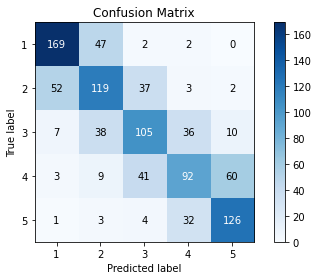

In [67]:
plot_confusion_matrix(tokenized_datasets['test']['labels'].cpu().detach().numpy(), 
                      predictions_all.cpu().detach().numpy(), 
                      classes=np.array([1,2,3,4,5]), 
                      title='Confusion Matrix')